In [9]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
# Some personnal imports
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:


num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))



Initialized
Minibatch loss at step 0: 22.319647
Minibatch accuracy: 10.9%
Validation accuracy: 13.5%
Minibatch loss at step 500: 3.193883
Minibatch accuracy: 74.2%
Validation accuracy: 76.8%
Minibatch loss at step 1000: 1.953925
Minibatch accuracy: 73.4%
Validation accuracy: 79.4%
Minibatch loss at step 1500: 1.273449
Minibatch accuracy: 77.3%
Validation accuracy: 80.8%
Minibatch loss at step 2000: 1.030296
Minibatch accuracy: 78.9%
Validation accuracy: 80.8%
Minibatch loss at step 2500: 1.091802
Minibatch accuracy: 78.1%
Validation accuracy: 82.2%
Minibatch loss at step 3000: 0.674320
Minibatch accuracy: 85.2%
Validation accuracy: 82.3%
Test accuracy: 87.8%


In [7]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

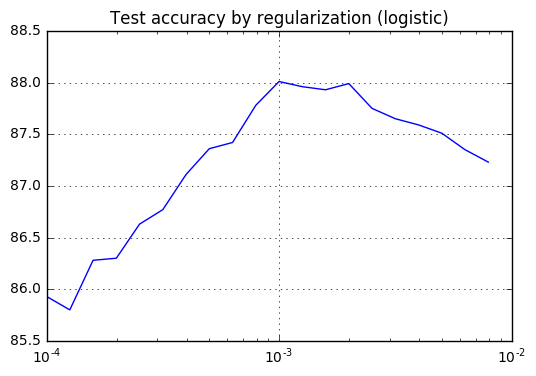

In [10]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

In [11]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [12]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 646.305542
Minibatch accuracy: 10.9%
Validation accuracy: 23.8%
Minibatch loss at step 500: 250.470474
Minibatch accuracy: 54.7%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 114.799133
Minibatch accuracy: 78.9%
Validation accuracy: 83.2%
Minibatch loss at step 1500: 68.418915
Minibatch accuracy: 81.2%
Validation accuracy: 83.9%
Minibatch loss at step 2000: 42.103352
Minibatch accuracy: 81.2%
Validation accuracy: 84.4%
Minibatch loss at step 2500: 25.401056
Minibatch accuracy: 82.8%
Validation accuracy: 86.3%
Minibatch loss at step 3000: 15.375445
Minibatch accuracy: 90.6%
Validation accuracy: 87.2%
Test accuracy: 92.5%


In [13]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:    
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))


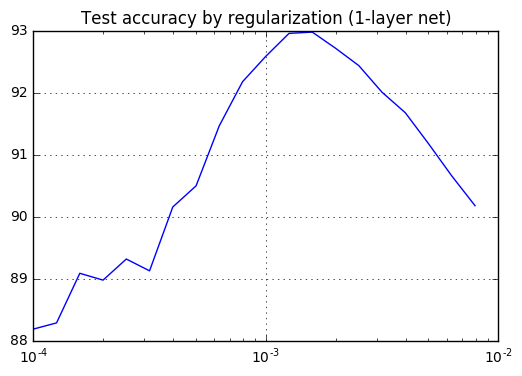

In [14]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

In [15]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [16]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 300.030579
Minibatch accuracy: 10.9%
Validation accuracy: 36.2%
Minibatch loss at step 2: 937.903564
Minibatch accuracy: 53.9%
Validation accuracy: 42.7%
Minibatch loss at step 4: 163.160553
Minibatch accuracy: 69.5%
Validation accuracy: 49.3%
Minibatch loss at step 6: 13.544139
Minibatch accuracy: 93.0%
Validation accuracy: 64.6%
Minibatch loss at step 8: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%
Minibatch loss at step 10: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%
Minibatch loss at step 12: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%
Minibatch loss at step 14: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%
Minibatch loss at step 16: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%
Minibatch loss at step 18: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%


In [17]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, 0.5)
  logits = tf.matmul(drop1, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [18]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 554.074707
Minibatch accuracy: 7.8%
Validation accuracy: 28.4%
Minibatch loss at step 2: 972.248535
Minibatch accuracy: 51.6%
Validation accuracy: 28.3%
Minibatch loss at step 4: 356.132874
Minibatch accuracy: 63.3%
Validation accuracy: 58.9%
Minibatch loss at step 6: 30.713923
Minibatch accuracy: 93.0%
Validation accuracy: 64.6%
Minibatch loss at step 8: 5.324423
Minibatch accuracy: 94.5%
Validation accuracy: 66.2%
Minibatch loss at step 10: 6.231687
Minibatch accuracy: 96.9%
Validation accuracy: 66.5%
Minibatch loss at step 12: 2.762099
Minibatch accuracy: 98.4%
Validation accuracy: 65.7%
Minibatch loss at step 14: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.9%
Minibatch loss at step 16: 5.029869
Minibatch accuracy: 96.9%
Validation accuracy: 65.4%
Minibatch loss at step 18: 1.497479
Minibatch accuracy: 98.4%
Validation accuracy: 66.3%
Minibatch loss at step 20: 0.124391
Minibatch accuracy: 99.2%
Validation accuracy: 66.7%
Minibat

In [20]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  logits = tf.matmul(lay2_train, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [21]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.314623
Minibatch accuracy: 11.7%
Validation accuracy: 20.7%
Minibatch loss at step 500: 1.209407
Minibatch accuracy: 82.0%
Validation accuracy: 85.8%
Minibatch loss at step 1000: 0.878828
Minibatch accuracy: 86.7%
Validation accuracy: 87.6%
Minibatch loss at step 1500: 0.717147
Minibatch accuracy: 88.3%
Validation accuracy: 88.3%
Minibatch loss at step 2000: 0.779405
Minibatch accuracy: 82.8%
Validation accuracy: 88.7%
Minibatch loss at step 2500: 0.657557
Minibatch accuracy: 85.9%
Validation accuracy: 89.1%
Minibatch loss at step 3000: 0.466839
Minibatch accuracy: 91.4%
Validation accuracy: 89.1%
Minibatch loss at step 3500: 0.530091
Minibatch accuracy: 92.2%
Validation accuracy: 89.3%
Minibatch loss at step 4000: 0.619293
Minibatch accuracy: 85.9%
Validation accuracy: 89.7%
Minibatch loss at step 4500: 0.483768
Minibatch accuracy: 93.0%
Validation accuracy: 90.0%
Minibatch loss at step 5000: 0.434806
Minibatch accuracy: 92.2%
Validation accurac

In [22]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  logits = tf.matmul(lay3_train, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [23]:
num_steps = 18001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.366406
Minibatch accuracy: 10.2%
Validation accuracy: 32.1%
Minibatch loss at step 500: 0.601784
Minibatch accuracy: 80.5%
Validation accuracy: 85.5%
Minibatch loss at step 1000: 0.458573
Minibatch accuracy: 86.7%
Validation accuracy: 87.7%
Minibatch loss at step 1500: 0.387943
Minibatch accuracy: 88.3%
Validation accuracy: 88.5%
Minibatch loss at step 2000: 0.531987
Minibatch accuracy: 82.0%
Validation accuracy: 89.4%
Minibatch loss at step 2500: 0.484231
Minibatch accuracy: 86.7%
Validation accuracy: 89.1%
Minibatch loss at step 3000: 0.206967
Minibatch accuracy: 92.2%
Validation accuracy: 89.3%
Minibatch loss at step 3500: 0.285864
Minibatch accuracy: 91.4%
Validation accuracy: 89.5%
Minibatch loss at step 4000: 0.473522
Minibatch accuracy: 85.2%
Validation accuracy: 89.7%
Minibatch loss at step 4500: 0.191185
Minibatch accuracy: 93.8%
Validation accuracy: 90.3%
Minibatch loss at step 5000: 0.228767
Minibatch accuracy: 93.0%
Validation accurac

In [24]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512
num_hidden_nodes3 = 256
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, 0.5)
  lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
  drop2 = tf.nn.dropout(lay2_train, 0.5)
  lay3_train = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
  drop3 = tf.nn.dropout(lay3_train, 0.5)
  logits = tf.matmul(drop3, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.80, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [25]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.651827
Minibatch accuracy: 14.8%
Validation accuracy: 20.8%
Minibatch loss at step 500: 0.822423
Minibatch accuracy: 77.3%
Validation accuracy: 84.3%
Minibatch loss at step 1000: 0.721339
Minibatch accuracy: 74.2%
Validation accuracy: 85.8%
Minibatch loss at step 1500: 0.544507
Minibatch accuracy: 85.2%
Validation accuracy: 86.2%
Minibatch loss at step 2000: 0.712346
Minibatch accuracy: 78.9%
Validation accuracy: 86.7%
Minibatch loss at step 2500: 0.559131
Minibatch accuracy: 82.0%
Validation accuracy: 86.9%
Minibatch loss at step 3000: 0.382113
Minibatch accuracy: 88.3%
Validation accuracy: 87.1%
Minibatch loss at step 3500: 0.479581
Minibatch accuracy: 89.1%
Validation accuracy: 87.5%
Minibatch loss at step 4000: 0.510685
Minibatch accuracy: 83.6%
Validation accuracy: 87.6%
Minibatch loss at step 4500: 0.609699
Minibatch accuracy: 85.2%
Validation accuracy: 88.0%
Minibatch loss at step 5000: 0.431252
Minibatch accuracy: 86.7%
Validation accurac